In [2]:
%matplotlib notebook

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
# from datetime import datetime

In [3]:
# Create plate class for keeping track of each plate
class Plate:
    def __init__(self, name, dt):
        self.name = name
        self.dt = dt
    def timepoint(self, tp):
        return tp-self.dt

# Create a timepoint class that keeps track of which plate was taken
class Timepoint:
    def __init__(self, name, dt, plate):
        self.name = name
        self.dt = dt
        self.plate = plate
    def recorded_timepoint(self):
        tp = self.plate.timepoint(self.dt)
        return tp.days*24 + tp.seconds/3600

In [4]:
def load_files(plate_path, timepoint_path):
#     plate_path = "plates.csv"
#     timepoint_path = "timepoints.csv"
    plate_df = pd.read_csv(plate_path)
    timepoint_df = pd.read_csv(timepoint_path)
    
    # Redefine the timepoint to a datetime object
    plate_df["Timepoint"] = pd.to_datetime(plate_df["Timepoint"])
    timepoint_df["Timepoint"] = pd.to_datetime(timepoint_df["Timepoint"])
    
    return (plate_df, timepoint_df)

In [5]:
def calculate_timepoints(plate_df, timepoint_df):
    plate_ar = np.empty(len(plate_df), dtype=Plate)
    for pix in range(len(plate_df)):
        plate = plate_df.iloc[pix]
        plate_ar[pix] = Plate(plate["plate_name"], plate["Timepoint"])
        
    timepoint_ar = np.empty(len(timepoint_df), dtype=Timepoint)
    for tix in range(len(timepoint_df)):
        tp = timepoint_df.iloc[tix]
        # Find the idx of the plate from the plate_id
        plate_name = plate_df[plate_df["plate_id"] == tp["plate_id"]]["plate_name"].values[0]
        for plate in plate_ar:
            if plate.name == plate_name:
                timepoint_ar[tix] = Timepoint(tp["Timepoint_name"], tp["Timepoint"], plate)
                break
                
    recorded_timepoints_ar = np.zeros_like(timepoint_ar, dtype=np.double)
    for rix in range(len(recorded_timepoints_ar)):
        recorded_timepoints_ar[rix] = timepoint_ar[rix].recorded_timepoint()
            
    records_df = pd.DataFrame({"plate_id": timepoint_df["plate_id"],
                               "time": recorded_timepoints_ar,
                               "comment": timepoint_df["Comment"]})   
    return records_df

In [9]:
# Folder for the files
exp_name = "EQ59_Gly_02022021"
acq_name = "TileScan_Tp30-38"
channel_str = "_ch00"

base_folder = f"D:/Tolga/Colony Images/{exp_name}/"
# base_folder = f"E:/Tolga/{exp_name}/"

plate_path = base_folder + f"{exp_name}_Plates.csv"
timepoint_path = base_folder + f"{exp_name}_Timepoints.csv"

# # Replace the metadata_path with
# metadata_path = base_folder + f"MetaData/{exp_name}_{acq_name}_Properties.xml"

# tree = ET.parse(metadata_path)    # xml tree of the current stage position
# root = tree.getroot()           # root of the xml tree

# image_xml = root[0]

# # Merged images folder
# merged_folder = base_folder + "ch00/Merged/"
# # Video folder
# # video_folder = base_folder + "Videos_Marked/"
# video_folder = base_folder + "ch00/Videos_Unmarked/"

In [10]:
plate_df, timepoint_df = load_files(plate_path, timepoint_path)
# Remove NA values
plate_df = plate_df.dropna()
timepoint_df = timepoint_df.dropna()
# Calculate the timepoints
records_df = calculate_timepoints(plate_df, timepoint_df)
# Dataframe of all the records
records_df = records_df.sort_values(by="time")

KeyError: 'Timepoint_name'

In [8]:
plate_path

'D:/Tolga/Colony Images/EQ59_Gly_02022021/EQ59_Gly_02022021_TileScan_Tp30-38/EQ59_Gly_02022021_Plates.csv'

In [2]:
# Folder for the files
exp_name = "EQ59_Gly_02022021"
acq_name = "TileScan_Tp30-38"
channel_str = "_ch00"

base_folder = f"D:/Tolga/Colony Images/{exp_name}/{exp_name}_{acq_name}/"
# base_folder = f"E:/Tolga/{exp_name}/"

# Replace the metadata_path with
metadata_path = base_folder + f"MetaData/{exp_name}_{acq_name}_Properties.xml"

tree = ET.parse(metadata_path)    # xml tree of the current stage position
root = tree.getroot()           # root of the xml tree

image_xml = root[0]

# Merged images folder
merged_folder = base_folder + "ch00/Merged/"
# Video folder
# video_folder = base_folder + "Videos_Marked/"
video_folder = base_folder + "ch00/Videos_Unmarked/"

In [3]:
# Collect information from the xml
dim_desc = cm.collectImageDim(image_xml)
xsz = dim_desc["xsz"]
ysz = dim_desc["ysz"]
zsz = dim_desc["zsz"]
xvoxel = dim_desc["xvoxel"]
yvoxel = dim_desc["yvoxel"]
zvoxel = dim_desc["zvoxel"]
xunit = dim_desc["xunit"]
yunit = dim_desc["yunit"]
zunit = dim_desc["zunit"]

# Tilescan info
tilescan_desc = cm.collectTileScan(image_xml)
xixar = tilescan_desc["xix_unique_ar"]
yixar = tilescan_desc["yix_unique_ar"]

tilescan is set


## Important!! 
### Each frame is scaled from a tilescan of 1024x1024 images, to a final 512x512 in the video.
* Collect the tilescan positions and obtain the scalex and scaley

* Scale xvoxel and yvoxel accordingly


In [4]:
tilescan_desc = cm.collectTileScan(image_xml)

tile_xcnt = tilescan_desc["tile_xcnt"]
tile_ycnt = tilescan_desc["tile_ycnt"]

scalex = 1.0/tile_xcnt/2
scaley = 1.0/tile_ycnt/2

tilescan is set


## Collect image sequence from 512x512 videos

In [5]:
# Go through each timepoint and each frame to collect the pixel and their locations that exceeds the threshold
def get_image_sequence(video_folder, acq_name, t_str):
    # Run through a single timepoint
    video_path = video_folder + f"{exp_name}_{acq_name}_{t_str}.avi"

    # Video capture object
    vidcap = cv2.VideoCapture(video_path)

    # Frame properties
    frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))

    img_seq = np.zeros((frame_height, frame_width, frame_count), np.uint8)
    for fix in range(frame_count):
        # Read frmae
        success,frame = vidcap.read()
        # Convert to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img_seq[:,:,fix] = frame_gray
        
    return img_seq

# frame info from test file

t_str = "t3"
video_path = video_folder + f"{exp_name}_{acq_name}_{t_str}.avi"
vidcap = cv2.VideoCapture(video_path)

# Frame properties
frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))

In [6]:
frame_count

235

## Interactive plot for locating center

<IPython.core.display.Javascript object>


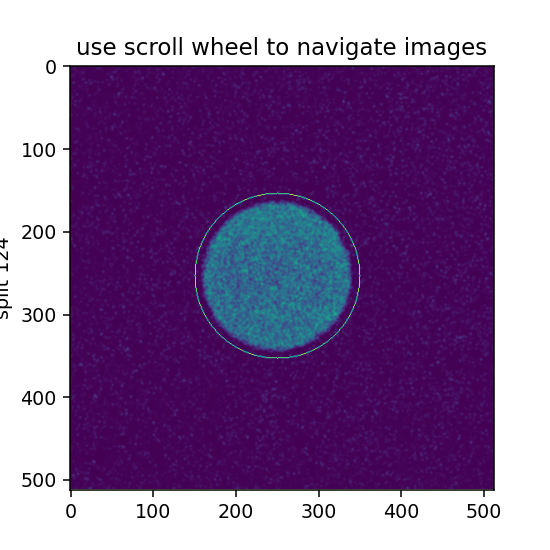

In [13]:
centerx = 250
centery = 254


zar = np.arange(0,zsz)
img_seq = get_image_sequence(video_folder, acq_name, t_str)
img_seq_maxz = np.zeros((frame_height, frame_width, len(zar))) # numpy 3d array image sequence to track max intensity images
for zix in range(len(zar)):
    roi_image = img_seq[:, :, zix]
    blurred_image = cv2.GaussianBlur(roi_image, (5,5), 0).astype(np.uint8)
    equalized_image = cv2.equalizeHist(blurred_image)
    ret, threshold_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
#     # Use threshold_image for manually measuring the radius and the center
#     img_seq_maxz[:, :, tix] = threshold_image
    # Use blurred_image for nice plots
    cv2.circle(blurred_image, (centerx, centery), 100, (255,255,255), 1)
    img_seq_maxz[:, :, zix] = blurred_image
        

# Plot the image sequence in a figure
fig_maxint_img, ax = plt.subplots(1, 1, figsize=(4,4))
tracker = tr.IndexTracker(ax, img_seq_maxz, 124)#, args_dict)
fig_maxint_img.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [14]:
img = img_seq[:,:,75]
radius = 100
circle_img = np.zeros((frame_height,frame_width), np.uint8)
cv2.circle(circle_img,(int(centerx),int(centery)), radius,1,thickness=-1)
masked_data = cv2.bitwise_and(img, img, mask=circle_img)
flip_masked_data = cv2.bitwise_and(img, img, mask=(1-circle_img))

masked_mean = masked_data.sum()/circle_img.sum()
flip_masked_mean = flip_masked_data.sum()/(1-circle_img).sum()

display(masked_mean)
display(flip_masked_mean)
display(img.mean())


4.576153038164051

0.9760192781945762

1.4074821472167969

## Run through each frame and reduce the frames in the video based on the threshold

In [16]:
# LxL blocks
pxl_threshold = 80
cnt_threshold = 3
block_length = 5

# reduced_height = int(frame_height/block_length)
# reduced_width = int(frame_width/block_length)

(reduced_height, reduced_width) = (512,512)
# zix = 55 # z index
# This part could be more efficient using built-in python capabilities
Rar_pxl = np.arange(2,int(reduced_height/2), dtype=np.int) # radius in pixels
central_average = np.zeros((len(Rar_pxl),frame_count), dtype=np.double)

for zix in range(frame_count):
    print("\rCalculating %d/%d..." % (zix, frame_count), end="")
    sys.stdout.flush()
    
    blurred_img = cv2.blur(img_seq[:,:,zix], (15,15))
    _, threshold_img = cv2.threshold(blurred_img, 10, 255, cv2.THRESH_BINARY)
#     reduced_avg_img = np.zeros((int(frame_height/block_length), 
#                         int(frame_width/block_length)))
#     reduced_cnt_img = np.zeros((int(frame_height/block_length), 
#                         int(frame_width/block_length)))
#     for yix in range(len(reduced_avg_img)):
#         for xix in range(len(reduced_avg_img[yix])):
#             block_img = img_seq[yix*block_length:(yix+1)*block_length,
#                                 xix*block_length:(xix+1)*block_length,
#                                 zix]
#             reduced_avg_img[yix,xix] = block_img.mean()
#             reduced_cnt_img[yix,xix] = (block_img > pxl_threshold).sum()
            
    
#     img = ((reduced_cnt_img > cnt_threshold).astype(np.uint8)*255)
    img = threshold_img
    for Rix in range(len(Rar_pxl)):
        radius = Rar_pxl[Rix]
        circle_img = np.zeros((512,512), np.uint8)
        cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius,1,thickness=-1)
        masked_data = cv2.bitwise_and(img, img, mask=circle_img)

        central_average[Rix, zix] = masked_data.sum()

Calculating 234/235...

In [17]:
threshold_img.shape

(512, 512)

<IPython.core.display.Javascript object>


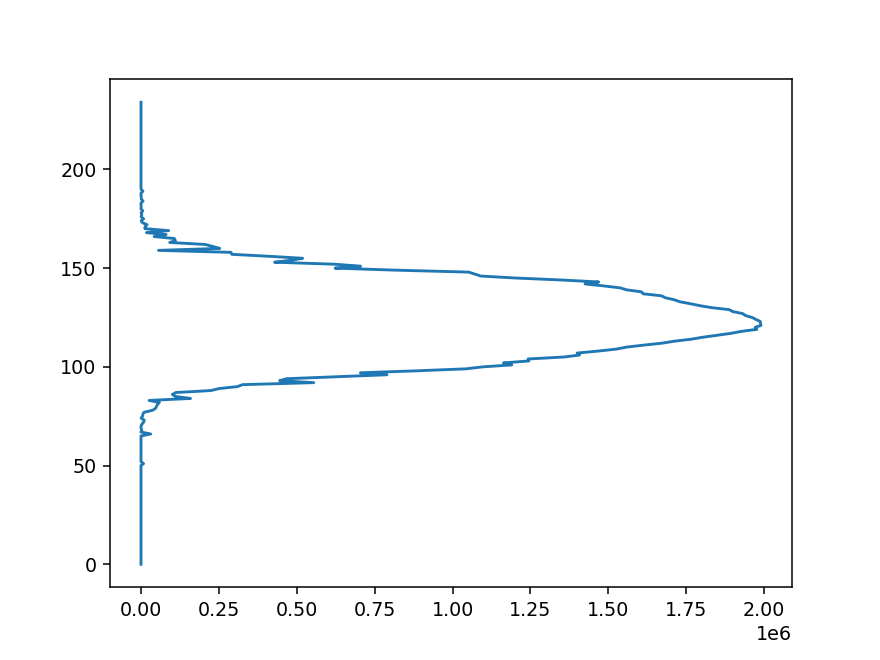

In [18]:
fig, ax = plt.subplots(1,1)
# ax.plot(Rar_pxl, central_average[:,120])
radz = Rar_pxl[np.argmax(central_average,axis=0)]
# ax.plot(zar, radz, 'o')
ax.plot(np.max(central_average,axis=0), zar)

### Reduced images from the frames of the videos

Calculating 120/235...

<IPython.core.display.Javascript object>


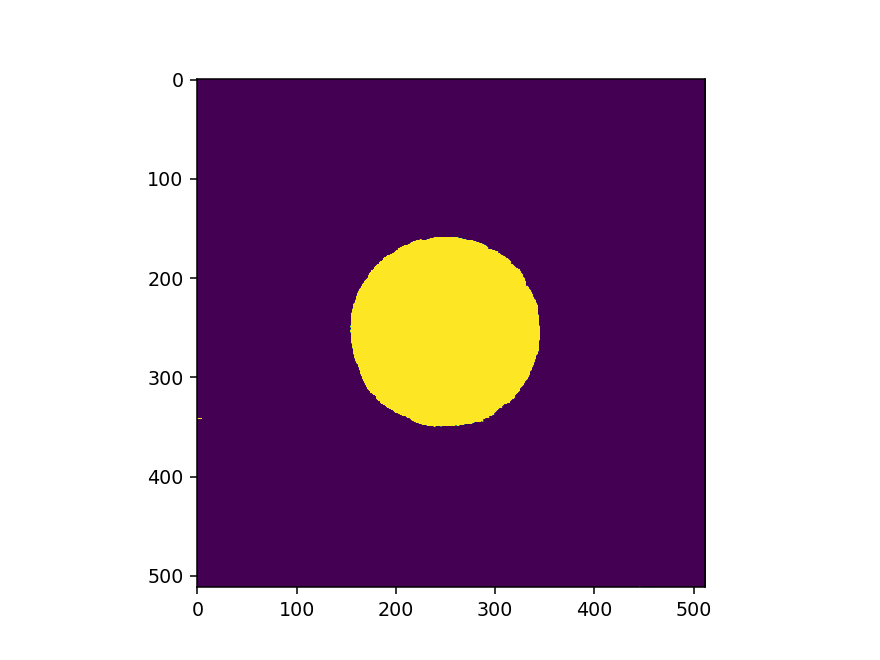

In [26]:
# Calculate circular average
# LxL blocks
pxl_threshold = 30
cnt_threshold = 3
block_length = 5

reduced_height = int(frame_height/block_length)
reduced_width = int(frame_width/block_length)

zix = 120
print("\rCalculating %d/%d..." % (zix, frame_count), end="")
sys.stdout.flush()
reduced_avg_img = np.zeros((int(frame_height/block_length), 
                    int(frame_width/block_length)))
reduced_cnt_img = np.zeros((int(frame_height/block_length), 
                    int(frame_width/block_length)))
img_seq = get_image_sequence(video_folder, acq_name, "t3")
# for yix in range(len(reduced_avg_img)):
#     for xix in range(len(reduced_avg_img[yix])):
#         block_img = img_seq[yix*block_length:(yix+1)*block_length,
#                             xix*block_length:(xix+1)*block_length,
#                             zix]
#         reduced_avg_img[yix,xix] = block_img.mean()
#         reduced_cnt_img[yix,xix] = (block_img > pxl_threshold).sum()
    
# fig,ax = plt.subplots(1,1)
# ax.imshow(reduced_cnt_img > cnt_threshold)

img = img_seq[:,:,zix]
# gray_img = cv2.cvtColor(img, cv2.)
blurred_img = cv2.blur(img, (15,15))
_, threshold_img = cv2.threshold(blurred_img, 10, 255, cv2.THRESH_BINARY)
# cv2.findContours(threshold_img, )
fig,ax = plt.subplots(1,1)
# ax.hist(blurred_img[blurred_img>3].flatten(), 150)
ax.imshow(threshold_img)

### Check the central_sum function for the given params

<IPython.core.display.Javascript object>


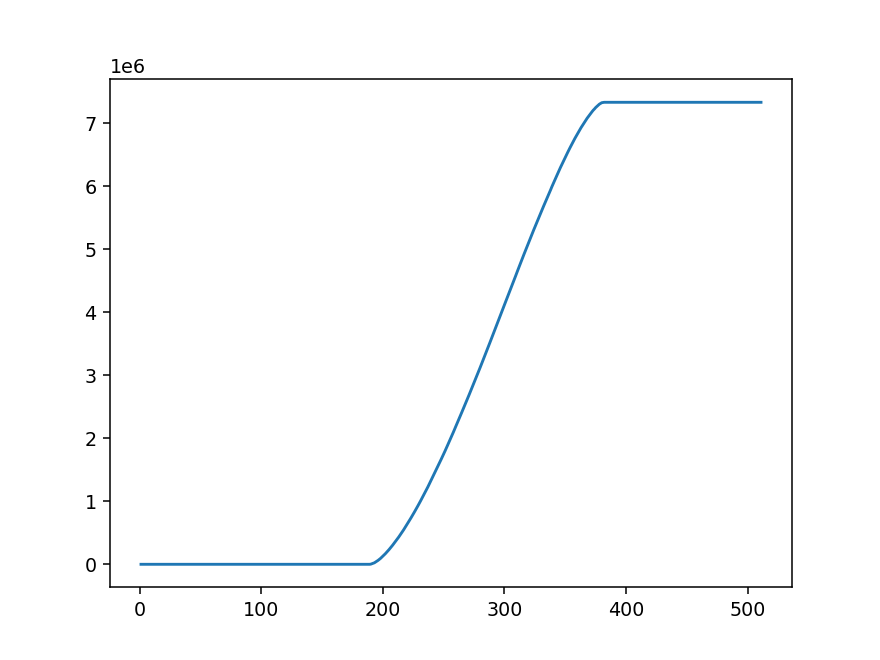

385

In [29]:
# img = ((reduced_cnt_img > cnt_threshold).astype(np.uint8)*255)
img = threshold_img
(reduced_height, reduced_width) = img.shape

Rar_pxl = np.arange(1,int(reduced_height/1), dtype=np.int) # radius in pixels
central_sum = np.zeros_like(Rar_pxl, dtype=np.double)

for Rix in range(len(Rar_pxl)):
    radius = Rar_pxl[Rix]

    circle_img = np.zeros((reduced_height,reduced_width), np.uint8)
    cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius,1,thickness=-1)
    masked_data = cv2.bitwise_and(img, img, mask=circle_img)

    central_sum[Rix] = masked_data.sum()
    
# Calculate the uniform fit (polyfit with degree=0)
uniform_fit = np.zeros_like(Rar_pxl[:-1])
for ix in range(len(Rar_pxl[:-1])):
    edge_ix = Rar_pxl[ix]
    uniform_fit[ix] = np.polyfit(Rar_pxl[edge_ix:], central_sum[edge_ix:], 0)
    
fig,ax = plt.subplots(1,1)
ax.plot(Rar_pxl, central_sum)

# edge_pxl = Rar_pxl[np.abs(np.diff(uniform_fit, prepend=200, append=0)) < 100][0]
edge_pxl = Rar_pxl[np.argmin(np.diff(uniform_fit))]
edge_pxl

### Central average throughout all scanning direcions (z and t)

In [30]:
# Calculate circular average
# LxL blocks
zar = np.arange(0,frame_count)
tar = np.arange(0,9)
# tar = np.array([7])
outer_radius_ar = np.zeros((len(tar), len(zar)))
masked_mean = np.zeros_like(outer_radius_ar)
flip_masked_mean = np.zeros_like(outer_radius_ar)
unmasked_mean = np.zeros_like(outer_radius_ar)
for tix in range(len(tar)):
    t_str = "t%d" % tar[tix]
    print(t_str)
    img_seq = get_image_sequence(video_folder, acq_name, t_str)
    for zix in range(len(zar)):
        zstrix = zar[zix]
        z_str = "z%03d" % (zstrix)

        print("\rCalculating %d/%d for tix=%d/%d" % (zstrix, frame_count, tix, len(tar)), end="")
        sys.stdout.flush()

#         reduced_avg_img = np.zeros((reduced_height, reduced_width))
#         reduced_cnt_img = np.zeros_like(reduced_avg_img, dtype=np.int)

#         for yix in range(len(reduced_avg_img)):
#             for xix in range(len(reduced_avg_img[yix])):
#                 block_img = img_seq[yix*block_length:(yix+1)*block_length,
#                                     xix*block_length:(xix+1)*block_length,
#                                     zix]
#                 reduced_avg_img[yix,xix] = block_img.mean()
#                 reduced_cnt_img[yix,xix] = (block_img > pxl_threshold).sum()

#         img = ((reduced_cnt_img > cnt_threshold).astype(np.uint8)*255)
        
        blurred_img = cv2.blur(img_seq[:,:,zix], (15,15))
        _, threshold_img = cv2.threshold(blurred_img, 10, 255, cv2.THRESH_BINARY)
        img = threshold_img
        
        (reduced_height, reduced_width) = img.shape

        Rar_pxl = np.arange(1,int(reduced_height), dtype=np.int) # radius in pixels
        central_sum = np.zeros_like(Rar_pxl, dtype=np.double)        
        
        # Calculate central sum: the sum of intensity of each pixel inside a circle
        for Rix in range(len(Rar_pxl)):
            radius = Rar_pxl[Rix]

            circle_img = np.zeros((reduced_height,reduced_width), np.uint8)
            cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius,1,thickness=-1)
            masked_data = cv2.bitwise_and(img, img, mask=circle_img)

            central_sum[Rix] = masked_data.sum()


        # Calculate the uniform fit (polyfit with degree=0)
        uniform_fit = np.zeros_like(Rar_pxl[:-1])
        for ix in range(len(Rar_pxl[:-1])):
            edge_ix = Rar_pxl[ix]
            uniform_fit[ix] = np.polyfit(Rar_pxl[edge_ix:], central_sum[edge_ix:], 0)
        try:
#             outer_radius_ar[tix, zix] = Rar_pxl[np.abs(np.diff(uniform_fit, prepend=200, append=0)) < 100][0]
            outer_radius_ar[tix,zix] = Rar_pxl[np.argmin(np.diff(uniform_fit))]
            radius = np.uint8(outer_radius_ar[tix,zix])
            
            full_img = img_seq[:,:,zix]
            full_circle_img = np.zeros((frame_height, frame_width), np.uint8)
            cv2.circle(full_circle_img, (centerx, centery), int(radius*block_length), 1, thickness=-1)
            
            masked_data = cv2.bitwise_and(full_img, full_img, mask=full_circle_img)
            flip_masked_data = cv2.bitwise_and(full_img, full_img, mask=(1-full_circle_img))
            
            masked_mean[tix,zix] = np.double(masked_data.sum())/full_circle_img.sum()
            flip_masked_mean[tix,zix] = np.double(flip_masked_data.sum())/(1-full_circle_img).sum()
            unmasked_mean[tix,zix] = full_img.mean()
        except IndexError:
            print("Index Error")
            outer_radius_ar[tix, zix] = 0
            radius = 0
            circle_img = np.zeros((reduced_height,reduced_width), np.uint8)
            cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius ,1,thickness=-1)
            masked_data = cv2.bitwise_and(img, img, mask=circle_img)
            flip_masked_data = cv2.bitwise_and(img, img, mask=(1-circle_img))
            
            masked_mean[tix,zix] = np.double(masked_data.sum())/circle_img.sum()
            flip_masked_mean[tix,zix] = np.double(flip_masked_data.sum())/(1-circle_img).sum()
            unmasked_mean[tix,zix] = img.mean()

t0
Calculating 52/235 for tix=0/9

<ipython-input-30-487a6bc5a39b>:72: RuntimeWarning: invalid value encountered in double_scalars
  flip_masked_mean[tix,zix] = np.double(flip_masked_data.sum())/(1-full_circle_img).sum()


Calculating 234/235 for tix=0/9t1
Calculating 234/235 for tix=1/9t2
Calculating 234/235 for tix=2/9t3
Calculating 234/235 for tix=3/9t4
Calculating 234/235 for tix=4/9t5
Calculating 234/235 for tix=5/9t6
Calculating 234/235 for tix=6/9t7
Calculating 234/235 for tix=7/9t8
Calculating 234/235 for tix=8/9

In [32]:
outer_radius_mm = xsz*tile_xcnt/reduced_height*xvoxel*outer_radius_ar/1e3
zar_mm = zar*zvoxel
df_dict = {"zar (mm)": zar_mm}
for tix in range(len(tar)):
    t_str = "t%02d" % (tix)
    df_dict[f"rad_{t_str} (mm)"] = outer_radius_mm[tix,:]
    df_dict[f"mean_{t_str}"] = unmasked_mean[tix,:]
    df_dict[f"col_mean_{t_str}"] = masked_mean[tix,:]
    df_dict[f"bg_mean_{t_str}"] = flip_masked_mean[tix,:]
    
df = pd.DataFrame(data = df_dict)
df.to_csv(base_folder + f"ch00/Resources/{acq_name}_Movie.csv")

df_metadata = pd.DataFrame({"type": "Movie",
                            "pxl_threshold": pxl_threshold,
                            "cnt_threshold": cnt_threshold,
                            "centerx": centerx,
                            "centery": centery,
                            "block_length": block_length},
                           index = [0])
df_metadata.to_csv(base_folder + f"ch00/Resources/{acq_name}_Movie_Metadata.csv")

In [33]:
base_folder

'D:/Tolga/Colony Images/EQ59_Gly_02022021/EQ59_Gly_02022021_TileScan_Tp30-38/'

<IPython.core.display.Javascript object>


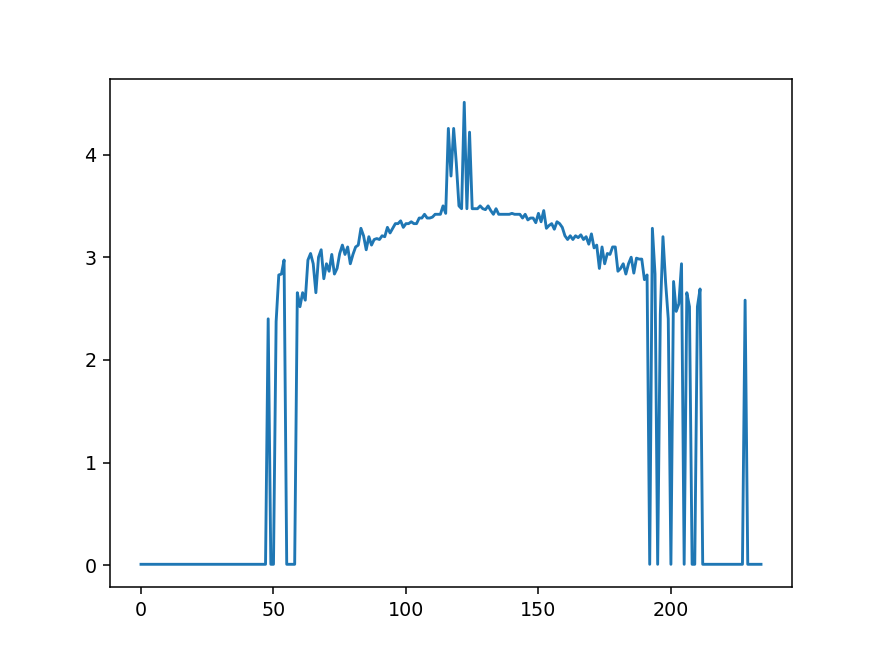

In [35]:
# df.plot(x="zar (mm)", y="bg_mean_t00")
fig,ax = plt.subplots(1,1)
ax.plot(zar, outer_radius_mm[3,:])
# ax.imshow(circle_img)
# csv_path

(9, 235)


<IPython.core.display.Javascript object>


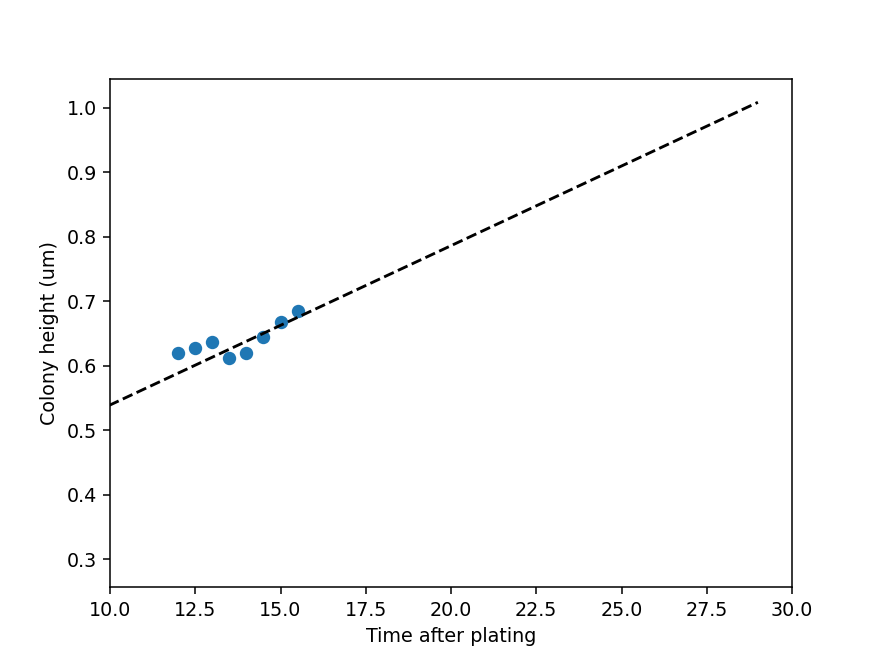

array([0.02468571, 0.29222857])

In [36]:
print(outer_radius_ar.shape)
tar = np.arange(0,8)
height = np.zeros_like(tar)
for tix in range(len(tar)):
    height[tix] = (outer_radius_ar[tix,:]>2).sum()
    
t = tar/2 + 12
h = -height*zvoxel
fig,ax = plt.subplots(1,1, dpi=100)
ax.plot(t, h, 'o')
ax.set_xlim(10,30)
# ax.set_ylim(0,4)
ax.set_xlabel(r'Time after plating')
ax.set_ylabel(r'Colony height (um)')

p = np.polyfit(t[2:],h[2:],1)
tt = np.arange(0,30)
hh = p[0]*tt + p[1]
ax.plot(tt,hh, 'k--')
p

In [39]:
df

,zar (mm),rad_t00 (mm),mean_t00,col_mean_t00,bg_mean_t00,rad_t01 (mm),mean_t01,col_mean_t01,bg_mean_t01,rad_t02 (mm),...,col_mean_t06,bg_mean_t06,rad_t07 (mm),mean_t07,col_mean_t07,bg_mean_t07,rad_t08 (mm),mean_t08,col_mean_t08,bg_mean_t08
0,-0.000,0.00909,0.857925,2.308642,0.857477,0.00909,1.200867,3.851852,1.200047,0.00909,...,6.975309,1.150445,0.00909,1.364841,5.604938,1.363531,0.00909,1.363186,7.765432,1.361207
1,-0.004,0.00909,1.212196,2.172840,1.211899,0.00909,1.207310,2.172840,1.207011,0.00909,...,3.246914,1.102887,0.00909,1.351471,2.691358,1.351057,0.00909,1.360298,2.000000,1.360100
2,-0.008,0.00909,1.125103,3.777778,1.124283,0.00909,1.151363,3.209877,1.150727,0.00909,...,2.037037,1.052522,0.00909,1.232254,8.925926,1.229876,0.00909,1.265808,3.086420,1.265245
3,-0.012,0.00909,1.117115,4.703704,1.116006,0.00909,1.102871,3.481481,1.102136,0.00909,...,5.123457,1.025044,0.00909,1.309937,4.629630,1.308910,0.00909,1.240757,1.345679,1.240725
4,-0.016,0.00909,1.122353,3.802469,1.121524,0.00909,1.111320,3.308642,1.110641,0.00909,...,6.197531,1.034095,0.00909,1.299549,6.938272,1.297806,0.00909,1.245804,2.160494,1.245521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,-0.920,0.00909,2.482758,3.382716,2.482479,0.00909,2.564842,7.617284,2.563281,0.00909,...,4.925926,2.863716,2.87244,3.259693,3.301203,2.652762,2.83608,3.385422,3.447420,2.917278
231,-0.924,2.78154,2.561729,2.636284,2.339365,0.00909,2.551804,5.740741,2.550818,0.00909,...,2.885582,NaN,2.58156,3.262074,4.397227,2.913920,3.02697,3.632965,3.632965,NaN
232,-0.928,2.65428,2.498184,2.734437,2.348275,0.00909,2.569885,3.432099,2.569619,0.00909,...,7.259259,2.863216,3.41784,3.427647,3.427647,NaN,2.69064,3.382992,3.925304,2.883925
233,-0.932,0.00909,2.508938,6.851852,2.507596,0.00909,2.522026,1.481481,2.522348,0.00909,...,4.854274,2.648338,3.04515,3.242527,3.242527,NaN,2.75427,3.632030,3.911497,3.085180


In [ ]:
# df.plot(x="zar (mm)", y="bg_mean_t00")

fig,ax = plt.subplots(1,1)
zar = df["zar (mm)"]
ax.plot(zar, df["bg_mean_t00"],
       zar, df["bg_mean_t01"],
       zar, df["bg_mean_t02"],
       zar, df["bg_mean_t03"],
       zar, df["bg_mean_t04"],
       zar, df["bg_mean_t05"],
       zar, df["bg_mean_t06"],
       zar, df["bg_mean_t07"])

In [ ]:
flip_masked_mean.dtype

In [ ]:
df.plot(x="zar (mm)", y="col_mean_t01")